In [11]:
import open3d as o3d
import open3d.t.io as o3dt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import laspy
from sklearn.metrics import confusion_matrix
import matplotlib.colors as mcolors
import joblib

In [12]:
data_folder = "../data/"
dataset_parma_labeled = f"{data_folder}updated_point_cloud.las"

In [13]:
las_data_labeled = laspy.read(dataset_parma_labeled)
points_parma = np.vstack((las_data_labeled.x, las_data_labeled.y, las_data_labeled.z)).transpose()
positional_offset_parma = points_parma.mean(axis=0)
points_parma -= positional_offset_parma

colors_parma = np.vstack((las_data_labeled.red, las_data_labeled.green, las_data_labeled.blue)).transpose() / 65535.0 # it is a 16 bit value and that is the maximum
features_parma = np.concatenate([points_parma, colors_parma], axis = 1)

scaler = MinMaxScaler()
features_scaled_parma = scaler.fit_transform(features_parma)

In [14]:
labels_parma = las_data_labeled.classification
print("Unique labels before remapping:", np.unique(labels_parma))
labels_parma = np.where(labels_parma > 2, labels_parma - 1, labels_parma)
print("Unique labels after remapping:", np.unique(labels_parma))

Unique labels before remapping: [0 1 3 4 5 6 7 8]
Unique labels after remapping: [0 1 2 3 4 5 6 7]


In [15]:
#%% Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(features_scaled_parma, labels_parma, test_size=0.4, random_state=42)

In [6]:
#%% Train Random Forest Classifier
rf_classifier_parma = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=42)
rf_classifier_parma.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=42)

In [7]:
# Make predictions
y_pred = rf_classifier_parma.predict(X_test)

In [8]:
#%% Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95     11772
           1       0.99      0.99      0.99    730762
           2       0.99      0.99      0.99    621710
           3       1.00      1.00      1.00    747820
           4       0.99      0.96      0.98      1908
           5       0.99      0.92      0.95      6479
           6       0.98      0.97      0.97    100966
           7       0.96      0.94      0.95    101263

    accuracy                           0.99   2322680
   macro avg       0.98      0.96      0.97   2322680
weighted avg       0.99      0.99      0.99   2322680



In [9]:
# Feature importance
importances = rf_classifier_parma.feature_importances_
feature_names = ["x", "y", "z", "red", "green", "blue"]
for name, importance in zip(feature_names, importances):
    print(f"Feature: {name}, Importance: {importance:.4f}")

Feature: x, Importance: 0.2238
Feature: y, Importance: 0.2284
Feature: z, Importance: 0.4352
Feature: red, Importance: 0.0408
Feature: green, Importance: 0.0300
Feature: blue, Importance: 0.0419


In [12]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 10984    336    168    122      0      0     43    119]
 [   109 726683    986    520      6     20   1330   1108]
 [    83   1364 617196    781      8     21    474   1783]
 [    15    615   1514 745129      0      0     91    456]
 [     0      2     48     16   1838      2      2      0]
 [     0     88    194     63      1   5969     25    139]
 [    24   2403    698     38      0      7  97447    349]
 [    42   2140   3086    354      0     35    393  95213]]


In [17]:
# Define a consistent colormap for classes
unique_labels = np.unique(y_test)
color_list = list(mcolors.TABLEAU_COLORS.values())[:len(unique_labels)]
label_to_color = {label: color_list[i % len(color_list)] for i, label in enumerate(unique_labels)}

In [18]:
# Create colors for the subsample
test_colors = np.array([label_to_color[label] for label in y_test])
pred_colors = np.array([label_to_color[label] for label in y_pred])

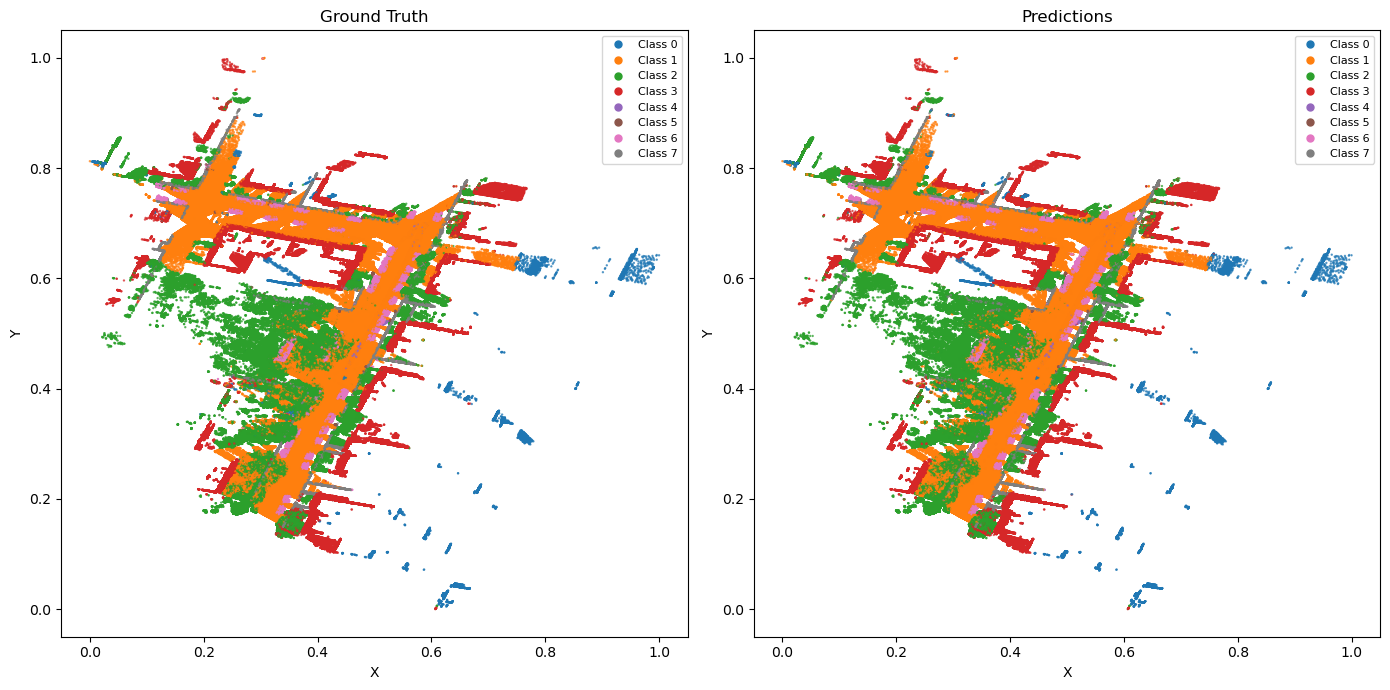

In [19]:
# Visualize the subsampled data
plt.figure(figsize=(14, 7))

# Scatter plot ground truth
plt.subplot(1, 2, 1)
plt.scatter(X_test[:, 0], X_test[:, 1], c=test_colors, s=0.5, alpha=0.7)
plt.title("Ground Truth")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color=color, markersize=5, linestyle='', label=f"Class {label}")
                    for label, color in label_to_color.items()], loc='upper right', fontsize=8)

# Scatter plot predictions
plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=pred_colors, s=0.5, alpha=0.7)
plt.title("Predictions")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color=color, markersize=5, linestyle='', label=f"Class {label}")
                    for label, color in label_to_color.items()], loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

In [21]:
# Save the trained classifier
model_filename = "random_forest_classifier.pkl"
joblib.dump(rf_classifier_parma, f"{data_folder}{model_filename}")
print(f"Model saved to {model_filename}")

Model saved to random_forest_classifier.pkl


In [20]:
# Load the saved classifier
model_filename = "random_forest_classifier.pkl"
rf_classifier_parma = joblib.load(f"{data_folder}{model_filename}")
print("Model loaded successfully")

Model loaded successfully


In [21]:
dataset_parma_other = f"{data_folder}LAS/21/18/Run 182099_20231206_131525_0018_SPATIAL_SUBSAMPLED_2023-12-24_20h54_30_626.las"

In [34]:
las_data_other = laspy.read(dataset_parma_other)
points_parma_other = np.vstack((las_data_other.x, las_data_other.y, las_data_other.z)).transpose()
positional_offset_parma_other = points_parma_other.mean(axis=0)
points_parma_other -= positional_offset_parma_other

colors_parma_other = np.vstack((las_data_other.red, las_data_other.green, las_data_other.blue)).transpose() / 65535.0 # it is a 16 bit value and that is the maximum
features_parma_other = np.concatenate([points_parma_other, colors_parma_other], axis = 1)

features_scaled_parma_other = scaler.transform(features_parma_other)

In [35]:
# Make predictions
y_pred_parma_other = rf_classifier_parma.predict(features_scaled_parma_other)

In [36]:
# Define a consistent colormap for classes
unique_labels = np.unique(y_pred_parma_other)
color_list = list(mcolors.TABLEAU_COLORS.values())[:len(unique_labels)]
label_to_color = {label: color_list[i % len(color_list)] for i, label in enumerate(unique_labels)}

In [37]:
pred_colors_parma_other = np.array([label_to_color[label] for label in y_pred_parma_other])

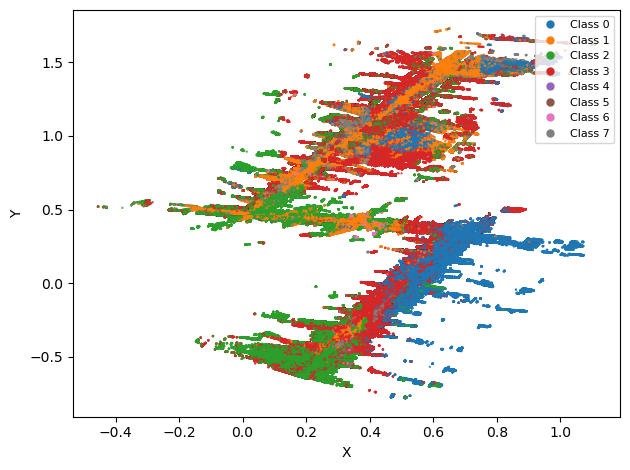

In [38]:
plt.scatter(features_scaled_parma_other[:, 0], features_scaled_parma_other[:, 1], c=pred_colors_parma_other, s=0.5, alpha=0.7)
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color=color, markersize=5, linestyle='', label=f"Class {label}")
                    for label, color in label_to_color.items()], loc='upper right', fontsize=8)

plt.tight_layout()

In [39]:
# Add classification directly to las_data
las_data_other.classification = y_pred_parma_other.astype(np.uint8)

# Optionally, save the updated LAS file
output_file = data_folder + "updated_point_cloud_other.las"
las_data_other.write(output_file)